### В данной домашней работе Вам предстоит отработать следующие 2 навыка: работа с пропущенными значениями и анализ выбросов.

In [8]:
import numpy as np
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/processed_data_with_new_features.csv', index_col='id')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!pwd

/content


In [10]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,NaN,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,NaN,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Никудышный гном случайно пролил кофе на папку с данными и кодом. К несчастью, из-за этого они с братьями потеряли кучу информации в столбиках **passenger_count** и **distance_km**.

In [11]:
### Выведите количество пропусков в данных колонках
### На всякий случай, проверьте целостность данных в остальных
data.isnull().sum()
### Your code is here

vendor_id                  0
passenger_count       145864
store_and_fwd_flag         0
distance_km           145864
log_trip_duration          0
anomaly                    0
traffic_jam                0
day_of_week_1              0
day_of_week_2              0
day_of_week_3              0
day_of_week_4              0
day_of_week_5              0
day_of_week_6              0
hour_1                     0
hour_2                     0
hour_3                     0
hour_4                     0
hour_5                     0
hour_6                     0
hour_7                     0
hour_8                     0
hour_9                     0
hour_10                    0
hour_11                    0
hour_12                    0
hour_13                    0
hour_14                    0
hour_15                    0
hour_16                    0
hour_17                    0
hour_18                    0
hour_19                    0
hour_20                    0
hour_21                    0
hour_22       

Начнем с **passenger_count**. Вообще говоря, изначально это была категориальная колонка, к которой мы применили технику OneHotEncoder. Чтобы избавиться от пропусков в данных, конечно, можно просто убрать все объекты, в которых есть пропуски, но тогда мы потеряем ценную информацию.

Воспользуйтесь относительно простым приемом из лекции: в указанной колонке заполните пропуски самым *популярным* значением среди неотсутствующих.

In [16]:
### Your code is here
df = data.copy()
popular_category = df['passenger_count'].value_counts().index[0]
df['passenger_count'] = df['passenger_count'].fillna(popular_category)
print(f'popular_category is : {round(popular_category,3)}')

popular_category is : 930.4


С колонкой **distance_km** поступим более интересным способом!

Чтобы заполнить пропуск в данной колонке для того или иного объекта, можно находить наиболее похожий на него объект и подглядывать в его значение **distance_km**. Для того, чтобы понять, насколько объекты похожи друг на друга, необходимо использовать Евклидово расстояние между этими самыми объектами в пространстве всех признаков!

С учетом количества объектов в нашем датасете и признаков, посчитать попарные расстояния будет мега-сложно. Поэтому давайте называть объекты похожими, если они принадлежат одной категории, составленной из следующих колонок:

1. vendor_id
2. store_and_fwd_flag
3. traffic_jam
4. month_2
5. month_3
6. month_4
7. month_5
8. month_6

Внутри каждой группы найдите среднее значение признака **distance_km** и заполните NaN'ы в объектах с пропуском в соответствии с тем, к какой категории относится данный объект. Похожее упражнение мы делали на практике в занятии!

**Hint**: достаточно просто взять group by по указанным выше категориальным колонкам и верно вставить полученный результат в исходную табличку.

P.S. Колонки выбраны случайным образом. Можно было взять и другую комбинацию.

In [17]:
### Your code is here
# Указанные категориальные колонки
categorical_columns = [
    'vendor_id', 'store_and_fwd_flag', 'traffic_jam',
    'month_2', 'month_3', 'month_4', 'month_5', 'month_6'
]

# Группировка данных по категориальным колонкам и вычисление среднего значения distance_km
grouped_data = df.groupby(categorical_columns)['distance_km'].mean().reset_index()

# Переименование колонки со средним значением для последующего слияния
grouped_data = grouped_data.rename(columns={'distance_km': 'mean_distance_km'})

# Объединение исходной таблицы с вычисленными средними значениями
df = df.merge(grouped_data, on=categorical_columns, how='left')

# Заполнение пропусков в distance_km
df['distance_km'] = df['distance_km'].fillna(df['mean_distance_km'])

# Удаление временной колонки со средними значениями
df = df.drop(columns=['mean_distance_km'])

# Сохранение результата в новый CSV файл (при необходимости)




In [24]:
### Убедимся, что пропусков не осталось

### Your code is here
df.head(20).to_csv('ans.csv', sep = ';', index = False)
df.isnull().sum()

vendor_id             0
passenger_count       0
store_and_fwd_flag    0
distance_km           0
log_trip_duration     0
anomaly               0
traffic_jam           0
day_of_week_1         0
day_of_week_2         0
day_of_week_3         0
day_of_week_4         0
day_of_week_5         0
day_of_week_6         0
hour_1                0
hour_2                0
hour_3                0
hour_4                0
hour_5                0
hour_6                0
hour_7                0
hour_8                0
hour_9                0
hour_10               0
hour_11               0
hour_12               0
hour_13               0
hour_14               0
hour_15               0
hour_16               0
hour_17               0
hour_18               0
hour_19               0
hour_20               0
hour_21               0
hour_22               0
hour_23               0
month_2               0
month_3               0
month_4               0
month_5               0
month_6               0
dtype: int64

### Теперь наши данные чисты! Замерьте качество модели на Кросс-Валидации

In [25]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

### Your code is here


model = LinearRegression()

X = df.drop('log_trip_duration', axis=1)
Y = df['log_trip_duration']

cv_result_1 = cross_validate(model, X, Y,
                             scoring='neg_mean_squared_error',
                             cv=selector, return_train_score=True)

cross_val_error = -np.mean(cv_result_1['test_score'])

print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")

MSLE на Кросс-валидации: 0.431


### Проведем анализ выбросов! Нарисуйте ящик с усами и гистограмму для таргетной переменной.

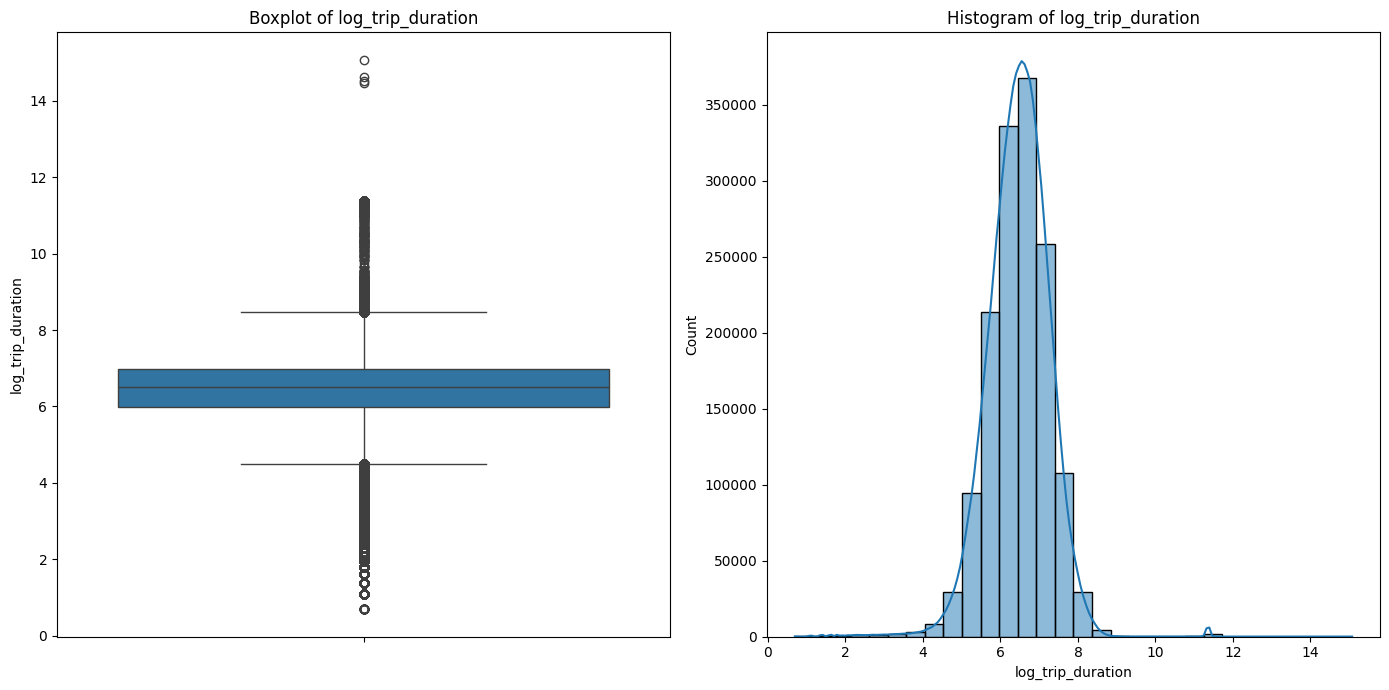

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

### Your code is here

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))



# Строим ящик с усами (boxplot)
sns.boxplot(y=df['log_trip_duration'], ax=axes[0])
axes[0].set_title('Boxplot of log_trip_duration')

# Строим гистограмму (histogram)
sns.histplot(df['log_trip_duration'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Histogram of log_trip_duration')

# Отображаем графики
plt.tight_layout()
plt.show()

Есть ли, на ваш взгляд, в данных выбросы?

Кажется, что да!

Давайте почистим их, удалив те объекты, таргеты которых находятся вне промежутка

(топ 99,5% значение;   топ 0,5% значение)

In [27]:
### Your code is here
# Вычисляем 0.5-й и 99.5-й перцентили
lower_bound = df['log_trip_duration'].quantile(0.005)
upper_bound = df['log_trip_duration'].quantile(0.995)

# Фильтруем данные, удаляя выбросы
df_filtered = df[(df['log_trip_duration'] > lower_bound) & (df['log_trip_duration'] < upper_bound)]

Снова замерьте качество на кросс-валидации, используя старый selector

In [28]:
### Your code is here
model = LinearRegression()

X_2 = df_filtered.drop('log_trip_duration', axis=1)
Y_2 = df_filtered['log_trip_duration']

cv_result_2 = cross_validate(model, X_2, Y_2,
                             scoring='neg_mean_squared_error',
                             cv=selector, return_train_score=True)

cross_val_error_2 = -np.mean(cv_result_2['test_score'])

print(f"MSLE на Кросс-валидации: {round(cross_val_error_2, 3)}")

MSLE на Кросс-валидации: 0.35
